<a href="https://colab.research.google.com/github/wajoud/Car-Lane-Change-Detection-/blob/master/Copy_of_LaneDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import glob

In [0]:
# os.chdir('/content/drive/My Drive/Colab Notebooks/Learning')
# os.chdir('/content/drive/My Drive/Colab Notebooks/Lane Change Detection (LCD)/Dataset/Lanes/Test/TestSeq04/image')
os.chdir('/content/drive/My Drive/Colab Notebooks/Lane Change Detection (LCD)/Dataset/Lanes/')
!ls

Readme	sample2.jpg  sample_final1.jpg	Test  Train


# Load Image

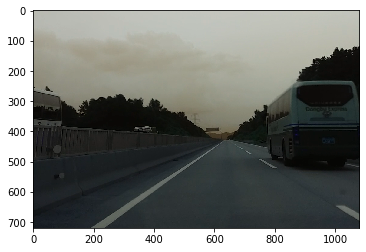

In [0]:
def load_img(f_name,ret_format=None):
  if ret_format==None:
    return cv2.imread(f_name)
  return cv2.imread(f_name,ret_format)


# Need to work here
def load_video(f_name):
  return None


# f_name = 'sample2.jpg'
# img = load_img(f_name)
# plt.figure()
# plt.imshow(img)



# -- uncomment from here---
os.chdir('/content/drive/My Drive/Colab Notebooks/Lane Change Detection (LCD)/Dataset/Lanes/Test/TestSeq00/image')
lanes = glob.glob('*.png')

lane_images = load_img(lanes[-1])
plt.imshow(lane_images)
img = lane_images

# Detect

---
1. Blur image - to clean out noise
---


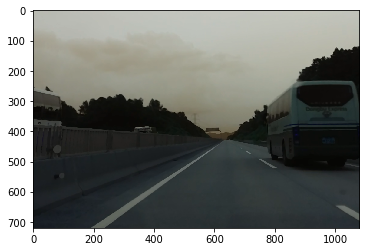

In [0]:
def blur_image(image,blur_method=None):
  if blur_method == 1: #median blur
    return cv2.medianBlur(image,5)
  else :
    return cv2.GaussianBlur(image,(5,5),5)

blur_img = blur_image(img,1)
plt.figure()
plt.imshow(blur_img)


---
2. Edges in the lane
----

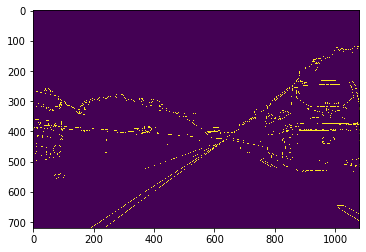

In [0]:
def edge_detection(image):
  return cv2.Canny(image,40,40)

img_edges = edge_detection(blur_img)
plt.figure()
plt.imshow(img_edges)

3. Region of Interest

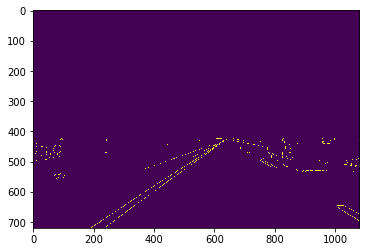

In [0]:
def roi(image):
  height,width = image.shape
  height_h = int(height/1.7)
  region = np.array([[(width,height_h),(0,height_h), (0, height), (width, height)]])
  mask = np.zeros_like(image)
  mask = mask.astype(np.uint8)
  mask_region = cv2.fillPoly(mask,region,255)
  return cv2.bitwise_and(image, mask_region)

masked_img = roi(img_edges)
plt.figure()
plt.imshow(masked_img)

4. Fetch all lanes

In [0]:
def fetch_only_lanes(image):
  lines = cv2.HoughLinesP(image, 2, np.pi / 180, 100, np.array([]), minLineLength = 50, maxLineGap = 2) # finding all lines
  all_lanes,left_lane,right_lane =[],[],[]
  if lines is not None:
    for lane in lines:
      x1,y1,x2,y2 = lane.reshape(4)
      slope,intersept = np.polyfit((x1,x2),(y1,y2),1)
      all_lanes.append((slope,intersept))
      if(slope<0):
        left_lane.append((slope,intersept))
      else:
        right_lane.append((slope,intersept))
  return all_lanes,left_lane,right_lane

all_lanes,left_side,right_side = fetch_only_lanes(masked_img)

In [0]:
all_lanes

[(-0.7258064516129036, 888.9354838709678),
 (-0.6488888888888886, 840.0177777777776),
 (-0.6571428571428559, 843.8285714285712),
 (-0.6511627906976739, 841.4651162790693),
 (-0.3611111111111107, 657.9166666666662),
 (-0.7222222222222234, 887.8888888888895),
 (0.19999999999999882, 298.20000000000107),
 (0.5576923076923054, 72.0576923076942),
 (0.6296296296296332, 17.88888888888534),
 (-0.7500000000000014, 896.7500000000007),
 (0.21999999999999872, 281.6200000000013)]

5. Identifying lane slope and intersept

-0.7500000000000014 896.7500000000007 -0.8
-0.6890835804189142 865.5295151168744 -0.7
-0.6488888888888886 840.0177777777776 -0.6
-0.3611111111111107 657.9166666666662 -0.4
0.20999999999999877 289.9100000000012 0.2
0.5936609686609693 44.973290598289765 0.6


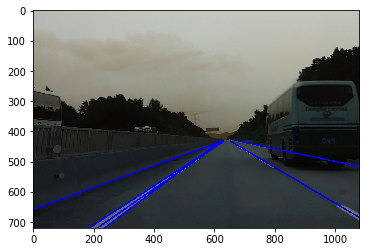

In [0]:
def give_coordinates(image,lane):
  slope,intercept = lane
  y1 = image.shape[0]
  y2 = int(y1*3/5)
  x1 = int((y1-intercept)/slope)
  x2 = int((y2-intercept)/slope)
  return np.array([x1,y1,x2,y2])


def extrct_lane(image,lanes):
  df  = pd.DataFrame(lanes)
  df[2] = round(df[0],1)
  a = df.groupby(2).mean()
  a["i"] = a.index
  proper_lanes = []
  for i,j,z in a.values:
    cordn = give_coordinates(image,(i,j))
    if (z!=0):
      print(i,j,z)
      proper_lanes.append([(cordn[0],cordn[1]),(cordn[2],cordn[3])])
  return proper_lanes


proper_lanes = extrct_lane(masked_img,all_lanes)
lanes_draw = img.copy()
for each_lane in proper_lanes:
  cv2.line(lanes_draw,(each_lane[0][0],each_lane[0][1]),(each_lane[1][0],each_lane[1][1]),(0,0,255),4)

plt.imshow(lanes_draw)

In [0]:
proper_lanes

NameError: ignored

Draw box in between region

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


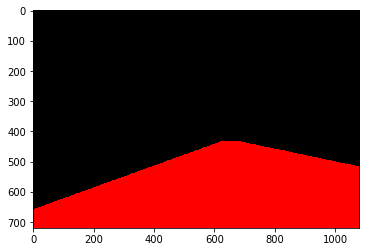

In [0]:
def draw_region_btwn_lane(image,lanes_draw):
  arr =  []
  arr.append(lanes_draw[0])
  sample_img = image.copy()
  sample_img = np.zeros(image.shape)
  for i in range(1,len(lanes_draw)):
    region=np.array([[
               (arr[-1][0][0],arr[-1][0][1]),
               (arr[-1][1][0],arr[-1][1][1]), 
               (lanes_draw[i][1][0], lanes_draw[i][1][1]),
               (lanes_draw[i][0][0],lanes_draw[i][0][1])
               ]])
    
    mask_region = cv2.fillPoly(sample_img.copy(),region,(255,0,0))
    # bit_img = cv2.bitwise_and(sample_img.copy(), mask_region)
    cv2.addWeighted(sample_img, 0.70, mask_region, 0.5,0, sample_img)
  
  plt.imshow(sample_img)
  plt.show()
  return sample_img

lane_objects = draw_region_btwn_lane(lanes_draw.copy(),proper_lanes)



In [0]:
pd.DataFrame(left_side).order_by(0)

AttributeError: ignored

In [0]:
right_side

# Trained Machine Analysing image

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Lane Change Detection (LCD)/')

In [0]:
trained_classifier = None
with open('trained_backup.p','rb') as fp:
  trained_classifier = pickle.load(fp)




(720, 1080, 3)
(720, 1080, 3)
[((864, 336), (1064, 536))]


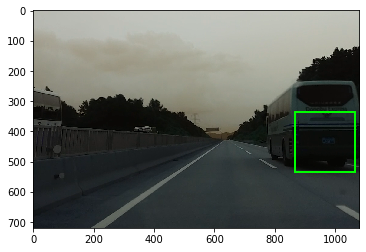

In [0]:
from skimage.feature import hog
pixels_in_cell = 16
HOG_orientations = 11
cells_in_block = 2
cells_in_step = 3 

def predict_object(masked_region_hog_feature_all,masked_region_resized_R):
  n_blocks_x = (masked_region_resized_R.shape[1] // pixels_in_cell)+1  
  n_blocks_y = (masked_region_resized_R.shape[0] // pixels_in_cell)+1

  # #nfeat_per_block = orientations * cells_in_block **2 
  blocks_in_window = (64 // pixels_in_cell)-1 
      
  steps_x = (n_blocks_x - blocks_in_window) // cells_in_step
  steps_y = (n_blocks_y - blocks_in_window) // cells_in_step

  rectangles_found = []

  for xb in range(steps_x):
      for yb in range(steps_y):
          y_position = yb*cells_in_step
          x_position = xb*cells_in_step
              
          hog_feat_sample = masked_region_hog_feature_all[y_position : y_position + blocks_in_window, x_position : x_position + blocks_in_window].ravel()
          x_left = x_position * pixels_in_cell
          y_top = y_position * pixels_in_cell
          
          # predict using trained SVM
          test_prediction = trained_classifier.predict(hog_feat_sample.reshape(1,-1))
          # test_prediction = grid.predict(hog_feat_sample.reshape(1,-1))
          
          if test_prediction == 1: 
              rectangle_x_left = np.int(x_left)
              rectangle_y_top = np.int(y_top)
              window_dim = np.int(200)
              rectangles_found.append(((rectangle_x_left, rectangle_y_top ),(rectangle_x_left + window_dim, rectangle_y_top + window_dim )))
  
  return rectangles_found
                
def resize_image_as_needed(image):
  resizing_factor = 2
  image_shape = image.shape
  L = image_shape[1]/resizing_factor
  W = image_shape[0]/resizing_factor
  image = cv2.resize(image, (np.int(L), np.int(W)))
  resized_image = image[:,:,0]
  return resized_image

def get_vehicle_box(test_image):
  masked_region = test_image[:,:]
  print(masked_region.shape)
  # masked_region = resize_image_as_needed(masked_region)
  print(masked_region.shape)
  masked_region_hog_feature_all, hog_img = hog(masked_region, orientations = 11, pixels_per_cell = (16, 16), cells_per_block = (2, 2), transform_sqrt = False, visualize = True, feature_vector = False)
  rectangles_found = predict_object(masked_region_hog_feature_all,masked_region)
  Image_with_Rectangles_Drawn = np.copy(test_image)
  print(rectangles_found)
  for rectangle in rectangles_found:
    cv2.rectangle(Image_with_Rectangles_Drawn, rectangle[0], rectangle[1], (0, 255, 0), 5)
  
  plt.imshow(Image_with_Rectangles_Drawn)
  cv2.imwrite('hello.jpg',Image_with_Rectangles_Drawn)
  return rectangles_found

vehicle_loc = get_vehicle_box(img)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


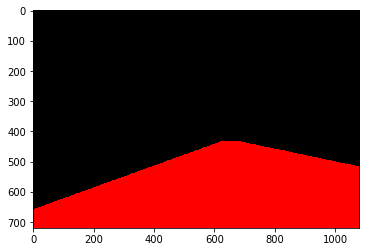

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


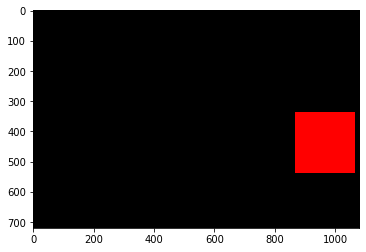

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


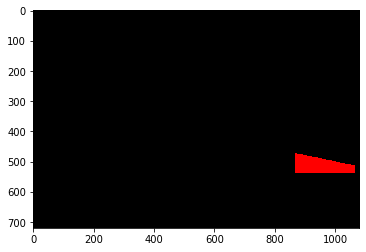

(720, 1080, 3)

In [0]:
vehicle_region_temp = cv2.rectangle(np.zeros(img.shape),vehicle_loc[0][0],vehicle_loc[0][1],(255,0,0),-1)
plt.figure()
plt.imshow(lane_objects)
cv2.imwrite("lane_region.jpg",lane_objects)
plt.show()
plt.figure()
plt.imshow(vehicle_region_temp)
cv2.imwrite("vehicle_region.jpg",vehicle_region_temp)
plt.show()
intersection_img = cv2.bitwise_and(lane_objects, vehicle_region_temp)
plt.figure()
plt.imshow(intersection_img)
cv2.imwrite("intersection_region.jpg",intersection_img)
plt.show()
# intersection_img[intersection_img[0][0]==255]
intersection_img.shape
# final_intersection = cv2.cvtColor(intersection_img,cv2.COLOR_BGR2GRAY)

In [0]:

gray = cv2.cvtColor(intersection_img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
print(len (gray[gray>0]))
if len(gray[gray>0]) >40:
  print("[!] Warning, you are about to collide")
else:
  print("[+] No collision")

8894
[!] Warning, you are about to collide


In [0]:
# zero_object = np.zeros(img.shape)
# region=cv2.rectangle(zero_object,vehicle_loc[0][0],vehicle_loc[0][1],(0,0,255),-1)
# # print(region)
# # plt.imshow(region)
# # plt.imshow(lane_objects)
# # region = cv2.cvtColor(region,cv2.COLOR_BGR2GRAY)
# # lane_objects = cv2.cvtColor(lane_objects,cv2.COLOR_BGR2GRAY)
# region_f = region.flatten().astype(int)
# lane_objects_f = lane_objects.flatten().astype(int)
# c = lambda x,y: np.int(x)==255 and np.int(y)==255
# cmp_obj = list(map(c,region_f,lane_objects_f))
# # np.max(region_f)
# # np.max(lane_objects_f)
# # plt.imshow(cv2.bitwise_and(region, lane_objects))
# for i in range(len(region_f)):
#   print(region_f[i])
#   if region_f[i]==255 and lane_objects_f[i]==255:
#     print("U Might Collide")
#     break
# # mask_region = cv2.fillPoly(sample_img.copy(),region,(250,250,0))
# print("Done")


In [0]:
def lanes_near_me(lanes):
  